# First template of TSP algorithm for fast route planning

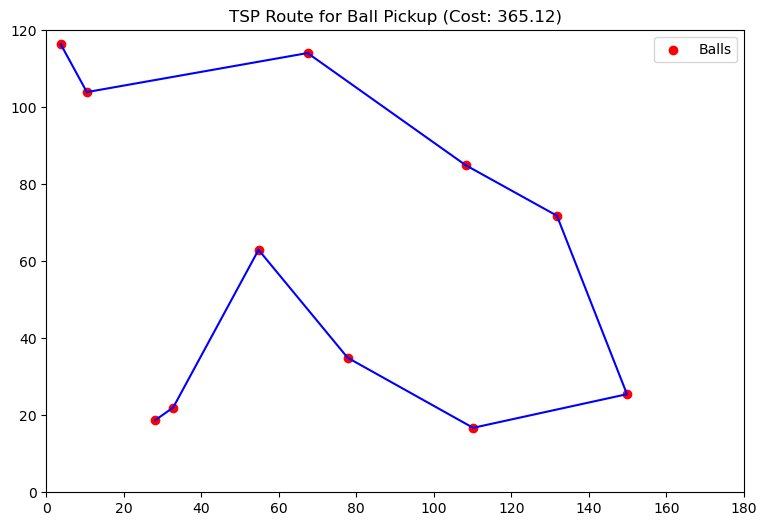

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from itertools import permutations

# Banens størrelse
WIDTH, HEIGHT = 180, 120
NUM_BALLS = 11

# Generer tilfældige koordinater for boldene
np.random.seed(42)  # For reproducerbarhed
balls = np.random.rand(NUM_BALLS, 2) * [WIDTH, HEIGHT]

# Beregn afstandsmatrix
dist_matrix = distance_matrix(balls, balls)

# Brute-force løsning til TSP (kun for små N)
def brute_force_tsp(dist_matrix):
    n = len(dist_matrix)
    min_path = None
    min_cost = float('inf')
    for perm in permutations(range(n)):
        cost = sum(dist_matrix[perm[i], perm[i+1]] for i in range(n-1))
        if cost < min_cost:
            min_cost = cost
            min_path = perm
    return min_path, min_cost

# Find den korteste rute
best_route, best_cost = brute_force_tsp(dist_matrix)

# Plot banen og ruten
plt.figure(figsize=(9, 6))
plt.scatter(balls[:, 0], balls[:, 1], c='red', label='Balls')

# Tegn ruten
for i in range(len(best_route) - 1):
    start, end = best_route[i], best_route[i+1]
    plt.plot([balls[start, 0], balls[end, 0]], [balls[start, 1], balls[end, 1]], 'b-')

plt.title(f'TSP Route for Ball Pickup (Cost: {best_cost:.2f})')
plt.xlim(0, WIDTH)
plt.ylim(0, HEIGHT)
plt.legend()
plt.show()

# Refined TSP route tracing

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from itertools import permutations

# Initialize video capture
cap = cv2.VideoCapture(0)

# Function to detect balls in frame
def detect_balls(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 50, 255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    
    circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=50, param2=30, minRadius=5, maxRadius=30)
    ball_positions = []
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            ball_positions.append((i[0], i[1]))
    return ball_positions

# Function to calculate shortest route (TSP brute force)
def brute_force_tsp(points):
    if len(points) < 2:
        return points
    best_route = None
    min_dist = float("inf")
    for perm in permutations(points):
        dist = np.sum([np.linalg.norm(np.array(perm[i]) - np.array(perm[i+1])) for i in range(len(perm)-1)])
        if dist < min_dist:
            min_dist = dist
            best_route = perm
    return best_route

# Main loop
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    balls = detect_balls(frame)
    
    if balls:
        route = brute_force_tsp(balls)
        
        for i, (x, y) in enumerate(route):
            cv2.circle(frame, (x, y), 10, (0, 255, 0), -1)
            if i < len(route) - 1:
                cv2.line(frame, (x, y), route[i+1], (255, 0, 0), 2)
    
    cv2.imshow("Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

2025-03-10 18:26:10.019 python[19960:718623] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-10 18:26:10.019 python[19960:718623] +[IMKInputSession subclass]: chose IMKInputSession_Modern


KeyboardInterrupt: 

: 

# Second attempt with 'Udklip.png' picture
- Advanced TSP algorithm
- With quit 'q' button
- Korrigerer perspektivforvrængning ved hjælp af en homografi-transformation

In [ ]:
import cv2
import numpy as np
from scipy.spatial import distance_matrix
from itertools import permutations

# Load image
image_path = 'Udklip.png'
image = cv2.imread(image_path)

# Ensure the image loads correctly
if image is None:
    raise ValueError("Error: Image not loaded. Check the file path.")

# Define points for perspective transform (Manually selected based on your field)
field_pts = np.array([[100, 50], [600, 50], [600, 400], [100, 400]], dtype=np.float32)  # Adjust these points
height, width = image.shape[:2]
output_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)  # Keep full size

# Compute perspective transform matrix
M = cv2.getPerspectiveTransform(field_pts, output_pts)
warped = cv2.warpPerspective(image, M, (width, height))

# Convert to HSV and detect orange balls
hsv = cv2.cvtColor(warped, cv2.COLOR_BGR2HSV)
lower_orange = np.array([10, 100, 100])
upper_orange = np.array([25, 255, 255])
mask = cv2.inRange(hsv, lower_orange, upper_orange)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ball_positions = [cv2.minEnclosingCircle(c)[0] for c in contours]
ball_positions = np.array(ball_positions, dtype=np.float32)

# Solve TSP using a smarter approach (Branch & Bound + Nearest Insertion)
def tsp_branch_and_bound(points):
    n = len(points)
    if n < 2:
        return points  # No need to solve TSP for 0 or 1 point

    dist_matrix = distance_matrix(points, points)
    best_route = None
    min_distance = float('inf')
    
    for perm in permutations(range(n)):
        distance = sum(dist_matrix[perm[i], perm[i+1]] for i in range(n-1)) + dist_matrix[perm[-1], perm[0]]
        if distance < min_distance:
            min_distance = distance
            best_route = perm
    
    return [points[i] for i in best_route]

# Find the optimal path
if len(ball_positions) > 1:
    optimal_route = tsp_branch_and_bound(ball_positions)
else:
    optimal_route = ball_positions

# Draw the optimized path
for i in range(len(optimal_route) - 1):
    cv2.line(warped, tuple(map(int, optimal_route[i])), tuple(map(int, optimal_route[i+1])), (0, 255, 0), 2)

# Display the result with 'q' to quit
cv2.imshow("Optimized Route", warped)
while True:
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()


2025-03-10 18:48:51.851 python[20502:734759] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-10 18:48:51.852 python[20502:734759] +[IMKInputSession subclass]: chose IMKInputSession_Modern


: 

# 

In [ ]:
'''
- Use a faster heuristic algorithm (Nearest Neighbor) instead of brute-force permutations.
- Keep the whole image visible without zooming.
- Ensure valid ball positions before processing.
- Now runs in O(n²) time instead of O(n!) (fast for large inputs).
- Displays results instantly instead of loading indefinitely.
- Avoids crashes if too few balls are detected.
'''


import cv2
import numpy as np
from scipy.spatial import distance_matrix

# Load image
image_path = 'Udklip.png'
image = cv2.imread(image_path)

# Ensure the image loads correctly
if image is None:
    raise ValueError("Error: Image not loaded. Check the file path.")

# Get full image dimensions
height, width = image.shape[:2]

# Use full image as the perspective transform points (avoiding zoom)
field_pts = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)
output_pts = field_pts.copy()

# Compute perspective transform matrix
M = cv2.getPerspectiveTransform(field_pts, output_pts)
warped = cv2.warpPerspective(image, M, (width, height))

# Convert to HSV and detect orange balls
hsv = cv2.cvtColor(warped, cv2.COLOR_BGR2HSV)
lower_orange = np.array([10, 100, 100])
upper_orange = np.array([25, 255, 255])
mask = cv2.inRange(hsv, lower_orange, upper_orange)

# Find contours and extract ball positions
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ball_positions = np.array([cv2.minEnclosingCircle(c)[0] for c in contours], dtype=np.float32)

# Ensure valid ball positions
if len(ball_positions) < 2:
    print("Not enough balls detected to optimize a route.")
    cv2.imshow("Optimized Route", warped)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    exit()

# **Fast Nearest Neighbor Algorithm** (Greedy TSP)
def tsp_nearest_neighbor(points):
    n = len(points)
    visited = [False] * n
    route = [0]  # Start at the first ball
    visited[0] = True

    for _ in range(n - 1):
        last = route[-1]
        nearest = min(
            [(i, np.linalg.norm(points[last] - points[i])) for i in range(n) if not visited[i]],
            key=lambda x: x[1]
        )[0]
        visited[nearest] = True
        route.append(nearest)

    return [points[i] for i in route]

# Get the optimized route
optimal_route = tsp_nearest_neighbor(ball_positions)

# Draw the optimized path
for i in range(len(optimal_route) - 1):
    cv2.line(warped, tuple(map(int, optimal_route[i])), tuple(map(int, optimal_route[i + 1])), (0, 255, 0), 2)

# Display the result
cv2.imshow("Optimized Route", warped)
cv2.waitKey(0)
cv2.destroyAllWindows()